In [8]:
%env CUDA_VISIBLE_DEVICES=7
import jax
from jax import jit, lax
from jax import numpy as jnp
from jax import random as jr
from jax import vmap
from jax.numpy import linalg as jla
from util import *
from simple_pytree import Pytree, static_field
import optax
from matplotlib import pyplot as plt

env: CUDA_VISIBLE_DEVICES=7


In [2]:
class FactRecall:
    def __init__(self, n_subject, n_relation, n_answer, n_noise, fact_dict, T, alpha = 0., EOS_token = False):
        self.n_subject = n_subject 
        self.n_relation = n_relation
        self.n_answer = n_answer
        self.n_noise = n_noise
        self.T = T
        self.dict = fact_dict
        p = 1./jnp.arange(1, n_subject + 1)**alpha
        self.p = p/p.sum()
        print(self.p)
        self.EOS = EOS_token
        
    def sample(self, key):
        skey, lkey, rkey, lrkey, nkey = jr.split(key, 5)
        subject = jr.choice(skey, self.n_subject, p=self.p)
        location = jr.choice(lkey, self.T-1)
        relation = jr.choice(rkey, self.n_relation)
        r_location = jr.choice(lrkey, self.T-2)
        r_location = r_location + (r_location >=location)
        x = jr.choice(nkey, jnp.arange(self.n_subject + self.n_relation, 
                                           self.n_subject + self.n_relation + self.n_noise), (self.T,))
        x = x.at[location].set(subject)
        if self.EOS:
            x = x.at[r_location].set(relation + self.n_subject)
            x = x.at[self.T-1].set(self.n_subject + self.n_relation + self.n_noise)
        else:
            x = x.at[self.T-1].set(relation + self.n_subject)
        
        answer = self.dict[subject, relation]
        
        return x, answer

In [3]:
rng = RNG(64)
n_subject = 16
n_relation = 4
n_answer_per = 8
n_answer = n_answer_per*n_relation
D = n_answer_per
n_noise = 20
vocab_size = n_subject + n_relation + n_noise+1
T = 32
# random fact dict
fact_dict = jnp.array([jr.choice(rng.next(), jnp.arange(n_answer_per*i, n_answer_per*(i+1)), (n_subject,)) for i in range(n_relation)]).T

# structured:
fact_dict = jnp.array([[int(j*n_answer_per/n_subject) + i*n_answer_per for j in jnp.arange(0, n_subject)] for i in range(n_relation)]).T

print(fact_dict)
problem = FactRecall(n_subject, n_relation, n_answer, n_noise, fact_dict,T,alpha=0., EOS_token=True)

[[ 0  8 16 24]
 [ 0  8 16 24]
 [ 1  9 17 25]
 [ 1  9 17 25]
 [ 2 10 18 26]
 [ 2 10 18 26]
 [ 3 11 19 27]
 [ 3 11 19 27]
 [ 4 12 20 28]
 [ 4 12 20 28]
 [ 5 13 21 29]
 [ 5 13 21 29]
 [ 6 14 22 30]
 [ 6 14 22 30]
 [ 7 15 23 31]
 [ 7 15 23 31]]
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


In [ ]:
## TODO: update this code to use flax.linen and not the pytree stuff, may not work with wte=static_field()
class Simple_TF(Pytree):
    vocab_size: int = static_field()
    d: int = static_field()
    embed_orth: bool = static_field()
    wte = static_field()

    def attn(self, x, A):
        T = x.shape[-2]
        attn = jnp.einsum("...ij,jk,...lk -> ...il", x, A, x)
        attn = jnp.where(jnp.tri(T), attn, -jnp.inf)
        attn = nn.softmax(attn)
        attn = jnp.einsum("...ij,...jk->...ik", attn, x)
        return attn
    
    def lin_attn(self, x, A):
        T = x.shape[-2]
        attn = jnp.einsum("...ij,jk,...lk -> ...il", x, A, x)
        attn = jnp.einsum("...ij,...jk->...ik", attn, x)
        return attn
    
    def embed(self, x):
        wte = self.wte[x]
        return wte

    def __init__(
        self,
        seq_len,
        vocab_size,
        output_size,
        d,
        embed_orth,
        key
        
    ):
        self.vocab_size = vocab_size
        self.d = d
        self.embed_orth = embed_orth
        
        self.wte = jnp.eye(self.vocab_size)
        if self.embed_orth == False:
            self.wte = jr.normal(key, (self.vocab_size, d))
            self.wte = jnp.diag(1/jnp.linalg.norm(self.wte, axis=1))@ self.wte
        
        self.A = 1e-5*jnp.ones([1, self.d, self.d]) #jnp.zeros([1, d, d])
        self.V = 1e-5*jnp.ones([self.d, output_size]) #jnp.zeros([d, output_size])

    def __call__(self, x):
        x = self.embed(x)
        
        # linear attention versus softmax attention
        attn = jax.vmap(self.lin_attn, (None, 0), -2)(x, self.A)
        # attn = jax.vmap(self.attn, (None, 0), -2)(x, self.A)
        
        attn = attn.reshape(*attn.shape[:-2], -1)
        attn = attn@self.V
        x = attn[..., -1, :]
        return nn.softmax(x)

In [ ]:
embed_orth = True # determines whether we use orthogonal or random embeddings
d = vocab_size # needed for one-hot embeddings

init_model = Simple_TF(T, vocab_size, n_answer, d, True, rng.next())

criterion = lambda f, y: -jnp.log(f[y])

@jit
def loss_fn(model, batch):
    x, y = batch
    return vmap(criterion)(model(x), y).mean()

In [6]:
def rel_accuracy(model, batch):
    x, y = batch
    return vmap(lambda fi, yi: jnp.floor(jnp.argmax(fi)/D) == jnp.floor(yi/D))(model(x), y).mean()

def rel_loss(model, batch):
    x, y = batch
    f = model(x)
    probs = vmap(lambda fi, yi : jnp.sum(fi * (jnp.floor(jnp.arange(0, n_answer)/D) == jnp.floor(yi/D)).astype(int)))(f, y)
    return -jnp.log(probs).mean()

def sub_accuracy(model, batch):
    x, y = batch
    return vmap(lambda fi, yi: (jnp.argmax(fi) % D) == (yi % D))(model(x), y).mean()

def sub_loss(model, batch):
    x, y = batch
    f = model(x)
    probs = vmap(lambda fi, yi : jnp.sum(fi * ((jnp.arange(0, n_answer) % D) == (yi % D)).astype(int)))(f, y)
    return -jnp.log(probs).mean()

@jit
def accuracy(model, batch):
    x, y = batch
    return vmap(lambda fi, yi: jnp.argmax(fi) == yi)(model(x), y).mean()

In [7]:
## Training Loop

testx, testy = vmap(problem.sample)(rng.next(2**16))

print("Training")
lr = 0.1
wd = 0.
steps = 2**13
save_every = steps // 128
batch_size = 2**10
max_size = 2**20 # 2**24
epoch_len = max_size // batch_size
sample_fn = jit(lambda k: vmap(problem.sample)(jr.split(k, epoch_len * batch_size)))


def batch_iterator(key):
    while True:
        key, subkey = jr.split(key)
        batches = sample_fn(subkey)
        for i in range(epoch_len):
            yield tree_map(lambda x: x[batch_size * i : batch_size * (i + 1)], batches)

@jit
def step_fn(model, batch, lr, wd):
    loss, g = jax.value_and_grad(loss_fn)(model, batch)
    g = tree_add_scalar_mul(g, wd, model)
    model = tree_add_scalar_mul(model, -lr, g)
    return model, loss


iterator = batch_iterator(rng.next())
model = init_model
train_loss = []
test_loss = []
schedule = optax.cosine_decay_schedule(lr, steps)

# opt_state = opt.init(model)
As = []
Vs = []
rel_accs = []
sub_accs = []
accs = []
rel_losses = []
sub_losses = []
for i in trange(steps):
    if i % save_every == 0:
        test_loss.append(loss_fn(model, (testx, testy)))
        rel_accs.append(rel_accuracy(model, (testx, testy)))
        rel_losses.append(rel_loss(model, (testx, testy)))
        sub_accs.append(sub_accuracy(model, (testx, testy)))
        sub_losses.append(sub_loss(model, (testx, testy)))
        accs.append(accuracy(model, (testx, testy)))
        As.append(model.A[0])
        Vs.append(model.V)
    model, loss = step_fn(model, next(iterator), lr=lr, wd=wd)
    train_loss.append(loss)

Training


  0%|          | 0/8192 [00:00<?, ?it/s]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman


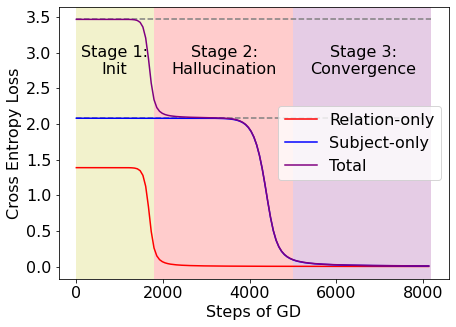

In [9]:
%matplotlib inline
plt.style.use('style.mplstyle')

fig, ax = plt.subplots(figsize = (7, 5))

plt.plot([0, steps], [np.log(32), np.log(32)], linestyle = 'dashed', color = 'gray')
plt.plot([0, steps], [np.log(8), np.log(8)], linestyle = 'dashed', color = 'gray')
plt.plot([save_every*i for i in range(len(test_loss))], rel_losses, color = 'r', label = 'Relation-only')
plt.plot([save_every*i for i in range(len(test_loss))], sub_losses, color = 'b', label = 'Subject-only')
plt.plot([save_every*i for i in range(len(test_loss))], test_loss, color = 'purple', label = 'Total')

plt.ylabel("Cross Entropy Loss")
plt.xlabel("Steps of GD")
plt.legend(loc = 'right')

# plt.vlines(1800, 0.0, np.log(32), linestyle = 'dashed', color = 'gray')
plt.axvspan(0, 1800, facecolor='y', alpha=0.2, zorder = -100)
plt.axvspan(1800, 5000, facecolor='red', alpha=0.2, zorder = -100)
plt.axvspan(5000, 8192, facecolor='purple', alpha=0.2, zorder = -100)

text_y = 2.7

plt.text(100, text_y, 'Stage 1:\nInit', color = 'k', multialignment='center')
plt.text(2200, text_y, 'Stage 2:\nHallucination', color = 'k', multialignment='center')
plt.text(5400, text_y, 'Stage 3:\nConvergence', color = 'k', multialignment='center')

plt.savefig("sequential_linear.pdf", bbox_inches='tight')
plt.show()